In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
import numpy as np
import folium
import geopandas as gpd
import folium
from folium.plugins import HeatMapWithTime
from folium.plugins import HeatMap
import matplotlib.dates as mdates
import itertools
from folium.plugins import MarkerCluster
import re
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
##from matplotlib.animation import FuncAnimation
##from scipy.stats import gaussian_kde
import time
from shapely.geometry import Point
###import contextily as ctx
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
# kmeans_spatial_clustering.py

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import json

# Load the data
df = pd.read_csv("Time_formatted_fixed_loc.csv")
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df[['Datetime', 'LAT', 'LON']].dropna()

# Standardize LAT and LON
scaler = StandardScaler()
df[['LAT_std', 'LON_std']] = scaler.fit_transform(df[['LAT', 'LON']])

# KMeans on standardized coordinates
kmeans = KMeans(n_clusters=5, random_state=42)
df['Hotspot'] = kmeans.fit_predict(df[['LAT_std', 'LON_std']])

# Load LA boundary GeoJSON
with open("la_boundary.geojson", "r") as f:
    la_boundary = json.load(f)

# Visualize using original coordinates
fig = px.scatter_mapbox(
    df.sample(frac=0.05, random_state=42),
    lat="LAT",
    lon="LON",
    color="Hotspot",
    zoom=9.5,
    center={"lat": 34.05, "lon": -118.25},
    height=800
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {"source": la_boundary, "type": "line", "color": "red"},
    ],
    margin={"r": 0, "t": 0, "l": 0, "b": 0}
)

fig.show()


In [3]:
df['Hotspot'].value_counts()

Hotspot
0    154953
3     66161
2     44947
4     36068
1     32427
Name: count, dtype: int64

In [4]:
import pandas as pd

df['Date'] = df['Datetime'].dt.to_period('D').apply(lambda r: r.start_time)

time_series = df.groupby(['Date', 'Hotspot']).size().reset_index(name='CrimeCount')

ts_pivot = time_series.pivot(index='Date', columns='Hotspot', values='CrimeCount').fillna(0)

ts_pivot.index = pd.to_datetime(ts_pivot.index)

ts_pivot = ts_pivot.sort_index()
full_index = pd.date_range(start=ts_pivot.index.min(), end=ts_pivot.index.max(), freq='D')
ts_pivot = ts_pivot.reindex(full_index, fill_value=0)
ts_pivot.index.name = 'Datetime'


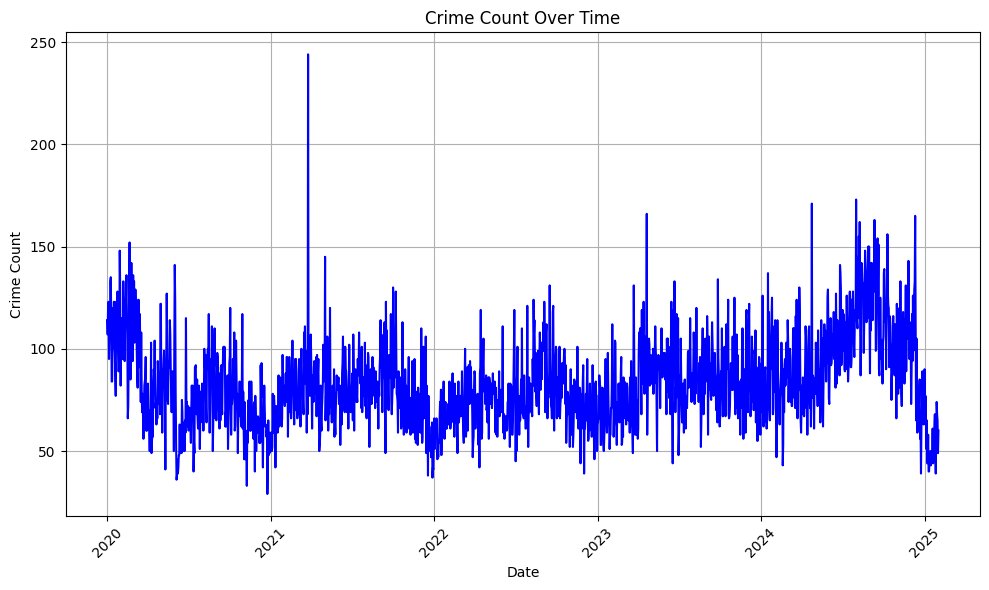

In [16]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[0], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

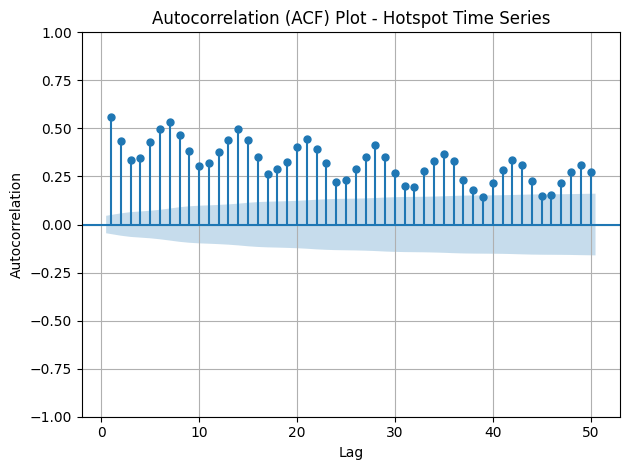

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[0].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

# Models

### ACD Test

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
##from statsmodels.stats.diagnostic import acorr_ljungbox
##import pmdarima as pm

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")

# === Load Time Series Data ===
# Example: ts_pivot should be a DataFrame with datetime index and hotspot series as columns
# You should replace this with actual loading logic
# ts_pivot = pd.read_csv("your_timeseries.csv", index_col=0, parse_dates=True)
hotspot_series = ts_pivot[0].values
dates = ts_pivot.index

# === Train-Test Split (90/10) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -4.5715
p-value: 0.0001
=> Stationary


# AR

Best AR Lag: 28
AR RMSE: 31.39
AR MAPE: 25.59%


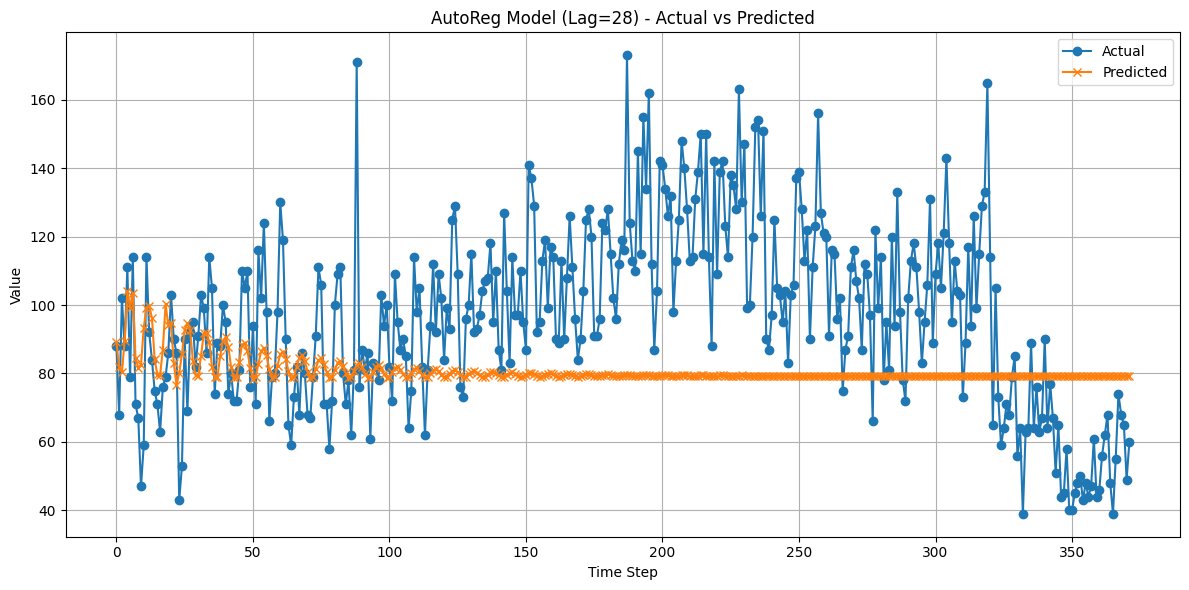

In [6]:
import numpy as np
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Preprocessing ---
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test Split (80/20 on time series directly) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train, test = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# --- Fit AR model with different lags and select the best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # testing lag values from 1 to 39
    try:
        model_ar = AutoReg(train.flatten(), lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train), end=len(train) + len(test) - 1)
        
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test.flatten())

        rmse = np.sqrt(mean_squared_error(actual, pred))

        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Results ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


plt.figure(figsize=(12, 6))
plt.plot(best_ar_actual, label='Actual', marker='o')
plt.plot(best_ar_pred, label='Predicted', marker='x')
plt.title(f'AutoReg Model (Lag={best_ar_lag}) - Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SARIMA

In [22]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Preprocessing ---
hotspot_series = ts_pivot[0].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test Split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train, test = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# --- Parameter Ranges ---
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            # Forecast the same length as the test set
            pred_scaled = model.forecast(steps=len(test))
            pred = inverse_transform(pred_scaled)
            actual = inverse_transform(test.flatten())

            rmse = np.sqrt(mean_squared_error(actual, pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = actual
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")

Best SARIMA Order: (1, 1, 1), Seasonal: (2, 0, 1) x 7
SARIMA RMSE: 25.97
SARIMA MAPE: 25.64%


### XGBoost

XGBoost RMSE: 20.03
XGBoost MAPE: 16.64%


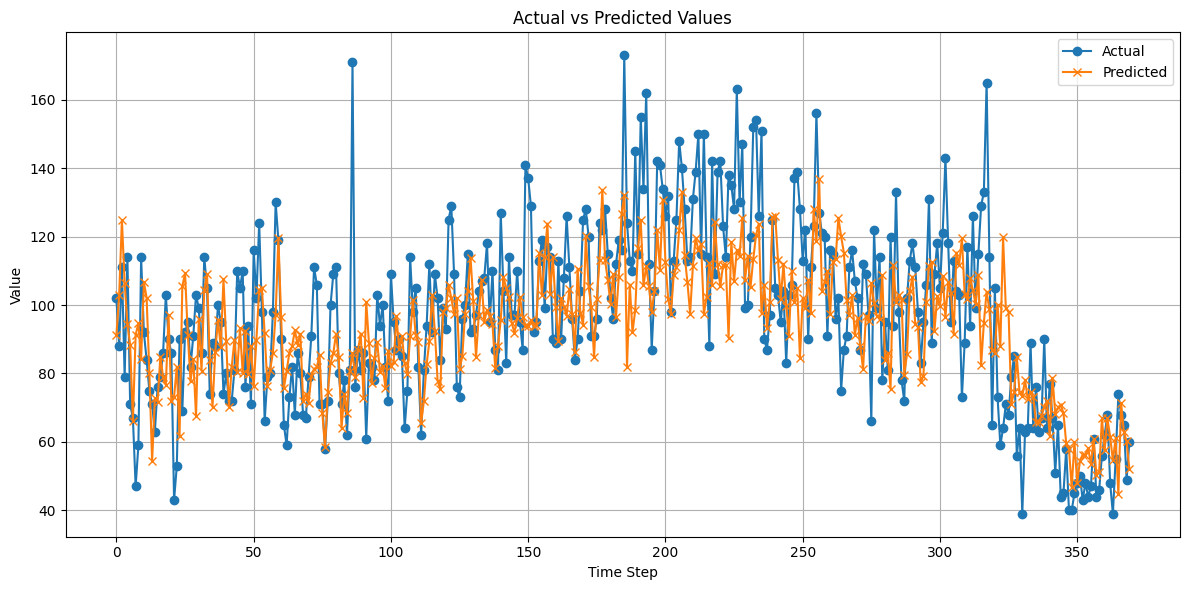

In [5]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[0].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

# --- Visualization: Actual vs Predicted ---
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### SARIMAX 


For lag = 1
Test RMSE: 21.7936
MAPE: 18.22%

For lag = 2
Test RMSE: 20.6440
MAPE: 17.49%

For lag = 3
Test RMSE: 20.4412
MAPE: 17.31%

For lag = 4
Test RMSE: 19.8771
MAPE: 16.85%

For lag = 6
Test RMSE: 18.1361
MAPE: 15.48%

For lag = 9
Test RMSE: 17.7714
MAPE: 15.30%

For lag = 12
Test RMSE: 17.7078
MAPE: 15.32%

For lag = 16
Test RMSE: 17.3211
MAPE: 15.45%

For lag = 24
Test RMSE: 17.0300
MAPE: 15.15%

For lag = 30
Test RMSE: 17.0889
MAPE: 15.27%

For lag = 40
Test RMSE: 17.0098
MAPE: 15.36%

For lag = 50
Test RMSE: 17.0693
MAPE: 15.33%


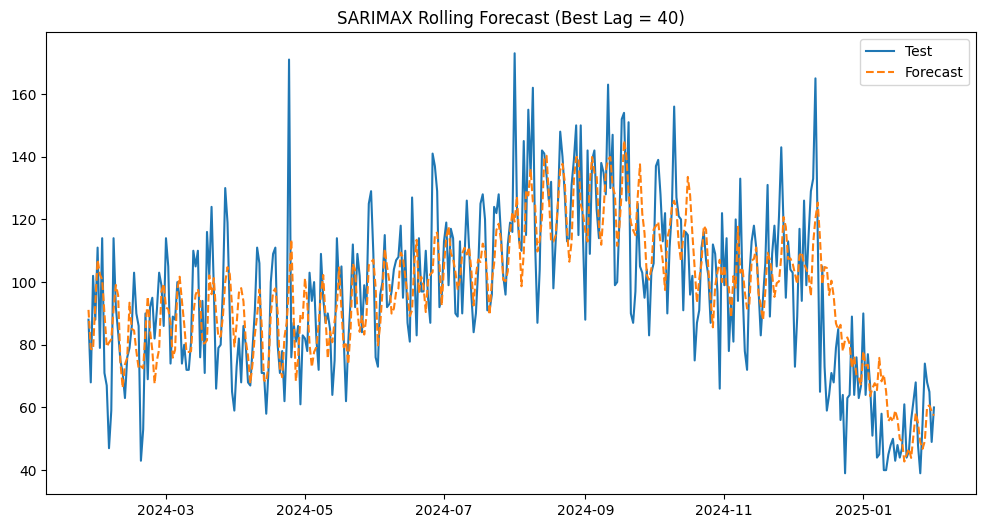

In [24]:
# ================== Cell 6: SARIMA Forecasting with Lag Optimization ==================
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[0].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


### LSTM

Epoch 1/100, Loss: 0.0165
Epoch 2/100, Loss: 0.0092
Epoch 3/100, Loss: 0.0086
Epoch 4/100, Loss: 0.0080
Epoch 5/100, Loss: 0.0074
Epoch 6/100, Loss: 0.0073
Epoch 7/100, Loss: 0.0074
Epoch 8/100, Loss: 0.0073
Epoch 9/100, Loss: 0.0072
Epoch 10/100, Loss: 0.0070
Epoch 11/100, Loss: 0.0067
Epoch 12/100, Loss: 0.0066
Epoch 13/100, Loss: 0.0071
Epoch 14/100, Loss: 0.0068
Epoch 15/100, Loss: 0.0067
Epoch 16/100, Loss: 0.0063
Epoch 17/100, Loss: 0.0064
Epoch 18/100, Loss: 0.0066
Epoch 19/100, Loss: 0.0064
Epoch 20/100, Loss: 0.0063
Epoch 21/100, Loss: 0.0066
Epoch 22/100, Loss: 0.0063
Epoch 23/100, Loss: 0.0062
Epoch 24/100, Loss: 0.0062
Epoch 25/100, Loss: 0.0063
Epoch 26/100, Loss: 0.0062
Epoch 27/100, Loss: 0.0059
Epoch 28/100, Loss: 0.0060
Epoch 29/100, Loss: 0.0060
Epoch 30/100, Loss: 0.0059
Epoch 31/100, Loss: 0.0059
Epoch 32/100, Loss: 0.0058
Epoch 33/100, Loss: 0.0058
Epoch 34/100, Loss: 0.0057
Epoch 35/100, Loss: 0.0058
Epoch 36/100, Loss: 0.0057
Epoch 37/100, Loss: 0.0058
Epoch 38/1

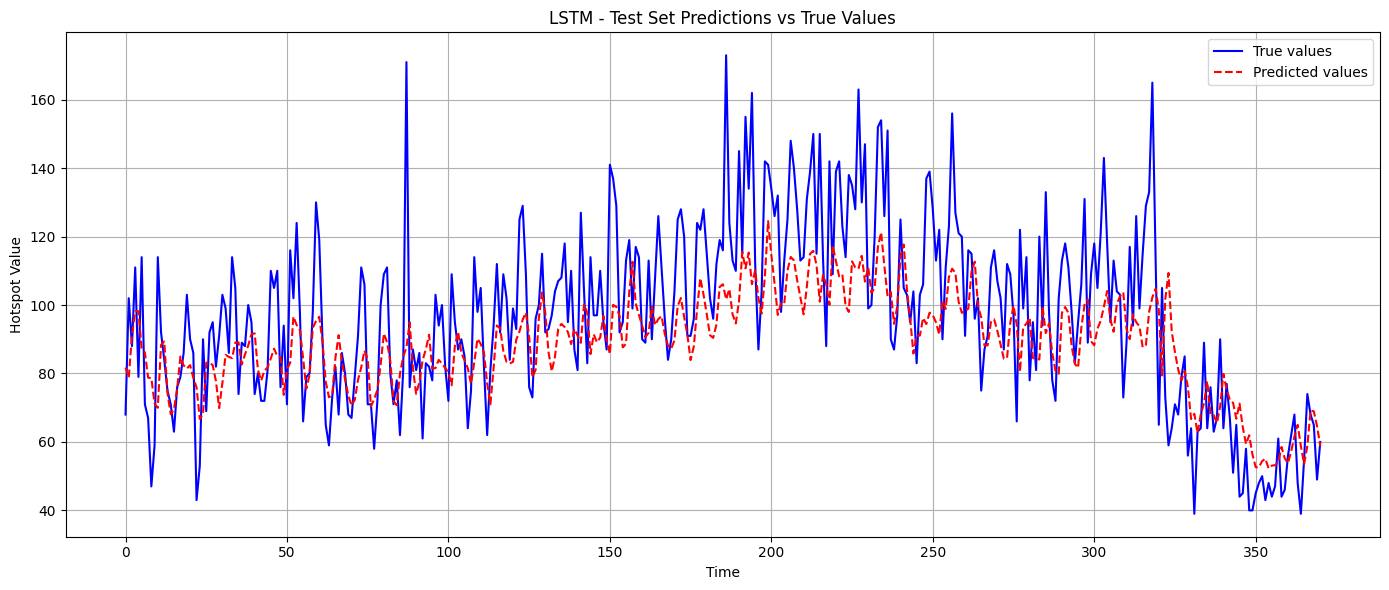

Test RMSE: 20.13
Test MAPE: 15.89%


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Prepare data
hotspot_series = ts_pivot[0].values.reshape(-1, 1)
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(hotspot_scaled)
X = X.reshape((X.shape[0], X.shape[1], 1))  # LSTM expects 3D input

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# Improved LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=128, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last output
        return self.fc(out)

model = LSTMModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100
model.train()
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb).squeeze()
        loss = loss_fn(pred, yb.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()
    y_true = y_test_tensor.numpy()

# Inverse transform
y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_true.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Metrics
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAPE: {mape * 100:.2f}%")


# Cluster 3

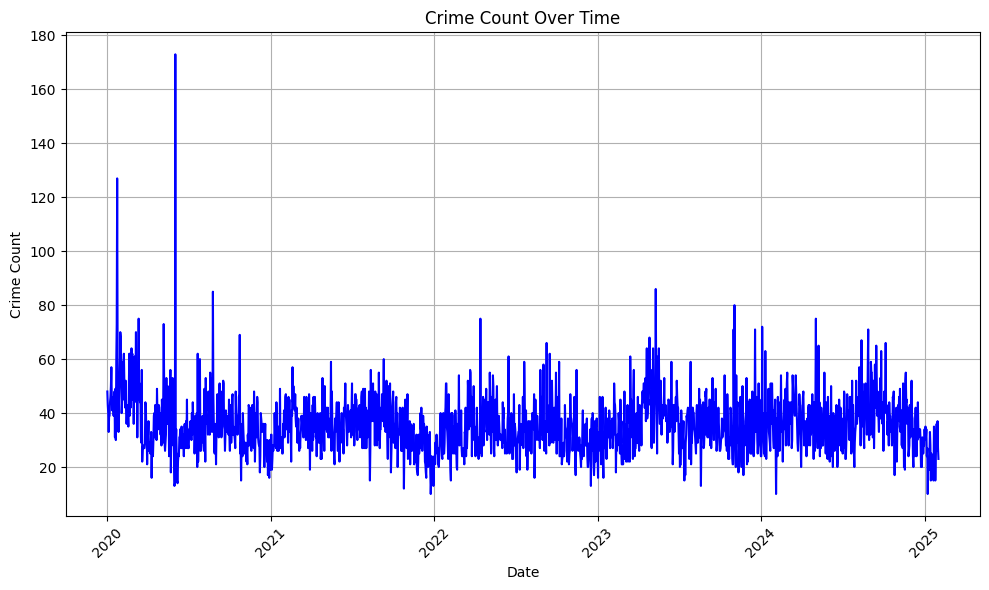

In [26]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(ts_pivot[0].index, ts_pivot[3], label='Crime Count', color='b')
plt.title('Crime Count Over Time')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

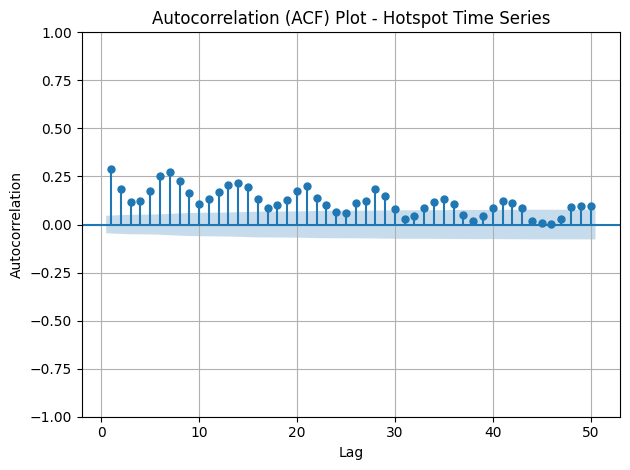

In [27]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

hotspot_series = ts_pivot[3].values

plt.figure(figsize=(10, 5))
plot_acf(hotspot_series, lags=50, zero=False)
plt.title("Autocorrelation (ACF) Plot - Hotspot Time Series")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX
##from statsmodels.stats.diagnostic import acorr_ljungbox
##import pmdarima as pm

# --- Suppress warnings and logs ---
warnings.filterwarnings("ignore")

hotspot_series = ts_pivot[3].values
dates = ts_pivot.index

# === Train-Test Split (90/10) ===
split_idx = int(len(hotspot_series) * 0.8)
train_data = hotspot_series[:split_idx]
test_data = hotspot_series[split_idx:]
test_dates = dates[split_idx:]

# === 1. ADF Test ===
print("== ADF Stationarity Test ==")
adf_result = adfuller(train_data)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("=> Stationary" if adf_result[1] < 0.05 else "=> Non-Stationary")


== ADF Stationarity Test ==
ADF Statistic: -5.0775
p-value: 0.0000
=> Stationary


In [29]:
import numpy as np
import warnings
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Preprocessing ---
hotspot_series = ts_pivot[3].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test Split (80/20 on time series directly) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train, test = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# --- Fit AR model with different lags and select the best ---
best_ar_rmse = float('inf')
best_ar_lag = None

for lag in range(1, 40):  # testing lag values from 1 to 39
    try:
        model_ar = AutoReg(train.flatten(), lags=lag, old_names=False).fit()
        pred_scaled = model_ar.predict(start=len(train), end=len(train) + len(test) - 1)
        
        pred = inverse_transform(pred_scaled)
        actual = inverse_transform(test.flatten())

        rmse = np.sqrt(mean_squared_error(actual, pred))

        if rmse < best_ar_rmse:
            best_ar_rmse = rmse
            best_ar_lag = lag
            best_ar_pred = pred
            best_ar_actual = actual
    except:
        continue

# --- Results ---
print(f"Best AR Lag: {best_ar_lag}")
print(f"AR RMSE: {best_ar_rmse:.2f}")
print(f"AR MAPE: {mean_absolute_percentage_error(best_ar_actual, best_ar_pred)*100:.2f}%")


Best AR Lag: 37
AR RMSE: 9.95
AR MAPE: 23.38%


In [30]:
import warnings
import itertools
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Preprocessing ---
hotspot_series = ts_pivot[3].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# --- Train/Test Split (80/20) ---
split_idx = int(len(hotspot_scaled) * 0.8)
train, test = hotspot_scaled[:split_idx], hotspot_scaled[split_idx:]

# --- Inverse transform helper ---
def inverse_transform(y_scaled):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# --- Parameter Ranges ---
p = d = q = range(0, 2)
P = D = Q = range(0, 3)
s = 7  # Weekly seasonality

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

# --- SARIMA Grid Search ---
for order in itertools.product(p, d, q):
    for seasonal_order in itertools.product(P, D, Q):
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)

            # Forecast the same length as the test set
            pred_scaled = model.forecast(steps=len(test))
            pred = inverse_transform(pred_scaled)
            actual = inverse_transform(test.flatten())

            rmse = np.sqrt(mean_squared_error(actual, pred))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_pred = pred
                best_actual = actual
        except:
            continue

# --- Output Best SARIMA Model ---
print(f"Best SARIMA Order: {best_order}, Seasonal: {best_seasonal_order} x {s}")
print(f"SARIMA RMSE: {best_rmse:.2f}")
print(f"SARIMA MAPE: {mean_absolute_percentage_error(best_actual, best_pred)*100:.2f}%")


Best SARIMA Order: (1, 0, 1), Seasonal: (2, 1, 1) x 7
SARIMA RMSE: 9.71
SARIMA MAPE: 23.17%


In [31]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# --- Prepare lag features ---
def create_lag_features(series, n_lags=36):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i - n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Use raw values
hotspot_series = ts_pivot[3].values.flatten()

# Create lagged features
n_lags = 12  # Use previous 12 time steps to predict next
X, y = create_lag_features(hotspot_series, n_lags=n_lags)

# Train/Test Split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# --- XGBoost Regressor ---
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Predictions ---
y_pred = model.predict(X_test)

# --- Evaluation ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAPE: {mape:.2f}%")

XGBoost RMSE: 10.52
XGBoost MAPE: 25.13%



For lag = 1
Test RMSE: 11.5467
MAPE: 26.33%

For lag = 2
Test RMSE: 10.5568
MAPE: 24.53%

For lag = 3
Test RMSE: 10.3453
MAPE: 24.20%

For lag = 4
Test RMSE: 10.2093
MAPE: 23.91%

For lag = 6
Test RMSE: 9.5100
MAPE: 22.61%

For lag = 9
Test RMSE: 9.1833
MAPE: 21.86%

For lag = 12
Test RMSE: 9.0930
MAPE: 21.80%

For lag = 16
Test RMSE: 9.0375
MAPE: 21.67%

For lag = 24
Test RMSE: 9.0229
MAPE: 21.54%

For lag = 30
Test RMSE: 9.0172
MAPE: 21.68%

For lag = 40
Test RMSE: 9.0871
MAPE: 21.99%

For lag = 50
Test RMSE: 9.1386
MAPE: 21.96%


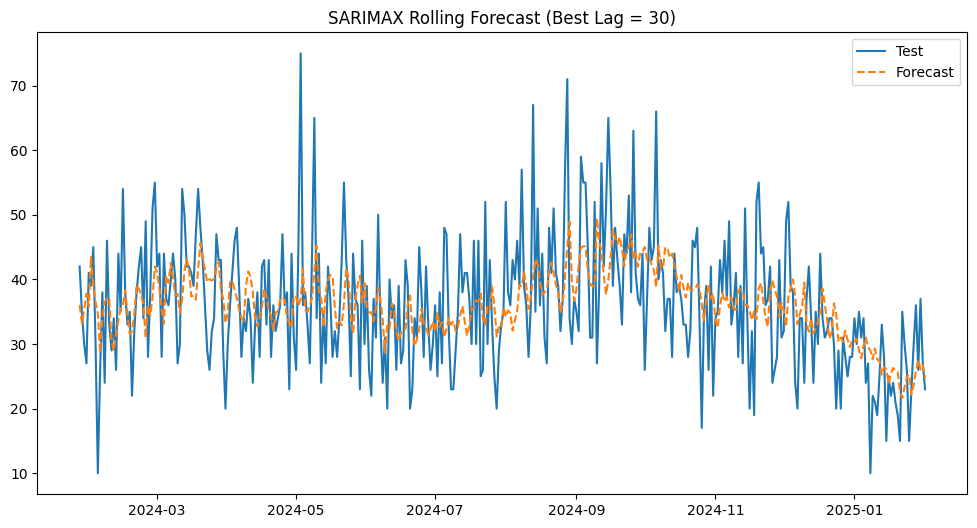

In [32]:
# ================== Cell 6: SARIMA Forecasting with Lag Optimization ==================
import torch.nn as nn
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

series = ts_pivot[3].astype(float).dropna()  # Example hotspot 0

lag_arr = [1, 2, 3, 4, 6, 9, 12, 16, 24, 30, 40, 50]

best_rmse = float('inf')
best_result = {}

for lag in lag_arr:
    train_size = int(len(series) * 0.8)
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    # Ensure correct data types and index
    train = pd.Series(train.values, index=train.index, dtype='float')
    test = pd.Series(test.values, index=test.index, dtype='float')

    model = SARIMAX(
        train,
        order=(lag, 0, 0),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)

    # Append test to Kalman filter
    res_ext = res.append(test)

    # One-step-ahead prediction
    pred = res_ext.get_prediction(start=test.index[0], end=test.index[-1], dynamic=False)
    y_pred = pred.predicted_mean

    if len(y_pred) == len(test):
        # Evaluate
        rmse = np.sqrt(mean_squared_error(test, y_pred))
        mape = mean_absolute_percentage_error(test, y_pred)
        print(f"\nFor lag = {lag}")
        print(f"Test RMSE: {rmse:.4f}")
        print(f"MAPE: {mape * 100:.2f}%")

        if rmse < best_rmse:
            best_rmse = rmse
            best_result = {
                "lag": lag,
                "test": test,
                "y_pred": y_pred
            }

# Optional: plot best forecast
if best_result:
    plt.figure(figsize=(12, 6))
    plt.plot(best_result["test"].index, best_result["test"], label="Test")
    plt.plot(best_result["y_pred"].index, best_result["y_pred"], label="Forecast", linestyle="--")
    plt.legend()
    plt.title(f"SARIMAX Rolling Forecast (Best Lag = {best_result['lag']})")
    plt.show()


Epoch 1, Loss: 0.0559
Epoch 2, Loss: 0.0500
Epoch 3, Loss: 0.0492
Epoch 4, Loss: 0.0486
Epoch 5, Loss: 0.0488
Epoch 6, Loss: 0.0490
Epoch 7, Loss: 0.0487
Epoch 8, Loss: 0.0487
Epoch 9, Loss: 0.0497
Epoch 10, Loss: 0.0499
Epoch 11, Loss: 0.0487
Epoch 12, Loss: 0.0486
Epoch 13, Loss: 0.0484
Epoch 14, Loss: 0.0489
Epoch 15, Loss: 0.0493
Epoch 16, Loss: 0.0489
Epoch 17, Loss: 0.0489
Epoch 18, Loss: 0.0487
Epoch 19, Loss: 0.0486
Epoch 20, Loss: 0.0490
Epoch 21, Loss: 0.0489
Epoch 22, Loss: 0.0484
Epoch 23, Loss: 0.0487
Epoch 24, Loss: 0.0485
Epoch 25, Loss: 0.0488
Epoch 26, Loss: 0.0486
Epoch 27, Loss: 0.0489
Epoch 28, Loss: 0.0486
Epoch 29, Loss: 0.0484
Epoch 30, Loss: 0.0498
Epoch 31, Loss: 0.0486
Epoch 32, Loss: 0.0484
Epoch 33, Loss: 0.0491
Epoch 34, Loss: 0.0490
Epoch 35, Loss: 0.0486
Epoch 36, Loss: 0.0493
Epoch 37, Loss: 0.0486
Epoch 38, Loss: 0.0484
Epoch 39, Loss: 0.0487
Epoch 40, Loss: 0.0488
Epoch 41, Loss: 0.0490
Epoch 42, Loss: 0.0492
Epoch 43, Loss: 0.0490
Epoch 44, Loss: 0.04

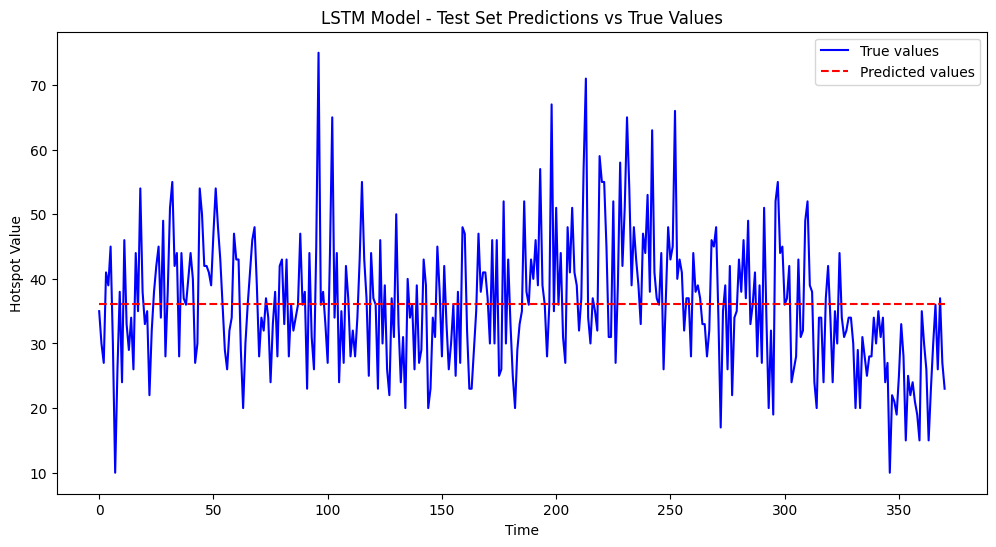

Test RMSE: 9.9979
Test MAPE: 24.49%


In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Assuming ts_pivot is a pandas DataFrame with time series data
hotspot_series = ts_pivot[3].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
hotspot_scaled = scaler.fit_transform(hotspot_series)

# Prepare sequences (7 weeks in → 1 week out)
def create_sequences(data, seq_len=7):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(data[i + seq_len])
    return np.array(X), np.array(y)

# Create sequences for input features and labels
X, y = create_sequences(hotspot_scaled)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert the data to tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Create DataLoader for the training set
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=4, batch_first=True)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.relu(out[:, -1, :])
        return self.fc(out)

# Initialize model, loss function, and optimizer
model = LSTMModel()
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
model.train()
for epoch in range(200):
    total_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# After training, evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = loss_fn(y_pred, y_test_tensor)
    print(f"Test Loss (L1): {test_loss.item():.4f}")

# Inverse transform to get the predictions in the original scale
y_test_original = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred.numpy().reshape(-1, 1))

# Plot the predictions vs true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="True values", color='blue')
plt.plot(y_pred_original, label="Predicted values", color='red', linestyle='--')
plt.title("LSTM Model - Test Set Predictions vs True Values")
plt.xlabel("Time")
plt.ylabel("Hotspot Value")
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape * 100:.2f}%")
